In [64]:
import os 
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D,Dropout, Resizing, Input, Normalization
from keras import models,layers
from keras.models import Sequential

from IPython import display


In [2]:
Data_path = ("data/")

data_dir = pathlib.Path(Data_path)

In [4]:
Data_path = ("data/")

data_dir = pathlib.Path(Data_path)

# Load the dataset
tf.keras.utils.get_file(
    'voicedataset.zip',
    origin='http://aiolearn.com/dl/datasets/voicedata.zip',
    extract=True,
    cache_dir='.', cache_subdir='data'
)

print("Dataset loaded successfully!")



178676098/178676098 [==============================] - 200s 1us/step
Dataset loaded successfully!


In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != 'voicedataset.zip')]
print("Commands: ", commands)

Commands:  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
#making training and testing dataset
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)
label_names = np.array(X_train.class_names)
print("Label names: ", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
Label names:  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
#squeexing the data
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test = X_test.map(squeeze, tf.data.AUTOTUNE)

In [8]:
X_train.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

tf.Tensor(
[[ 1.4648438e-03  4.5776367e-03  2.9602051e-03 ...  3.2653809e-03
   2.5634766e-03  3.6926270e-03]
 [ 6.9885254e-03  5.8898926e-03  6.7749023e-03 ...  9.4604492e-03
   8.2092285e-03  8.0566406e-03]
 [ 0.0000000e+00  8.5449219e-04 -3.9672852e-04 ...  3.7231445e-03
  -1.2817383e-03 -3.2043457e-03]
 ...
 [-1.3122559e-03 -1.6174316e-03 -2.5329590e-03 ... -2.9602051e-03
  -2.7770996e-03 -2.4719238e-03]
 [ 6.1035156e-05  3.0517578e-05 -3.0517578e-05 ... -1.5258789e-04
   3.0517578e-05  2.1362305e-04]
 [-3.0517578e-04 -2.2277832e-03 -2.8686523e-03 ... -3.0517578e-05
   2.7465820e-04  1.0375977e-03]], shape=(64, 16000), dtype=float32)
['down' 'go' 'right' 'no' 'down' 'left' 'yes' 'go' 'stop' 'go' 'left' 'up'
 'down' 'left' 'left' 'down' 'down' 'down' 'go' 'no' 'yes' 'right' 'up'
 'down' 'down' 'no' 'up' 'up' 'go' 'yes' 'yes' 'no' 'stop' 'stop' 'up'
 'go' 'right' 'stop' 'left' 'down' 'no' 'down' 'down' 'up' 'no' 'down'
 'down' 'go' 'stop' 'yes' 'no' 'stop' 'up' 'stop' 'right' 'go' 'y

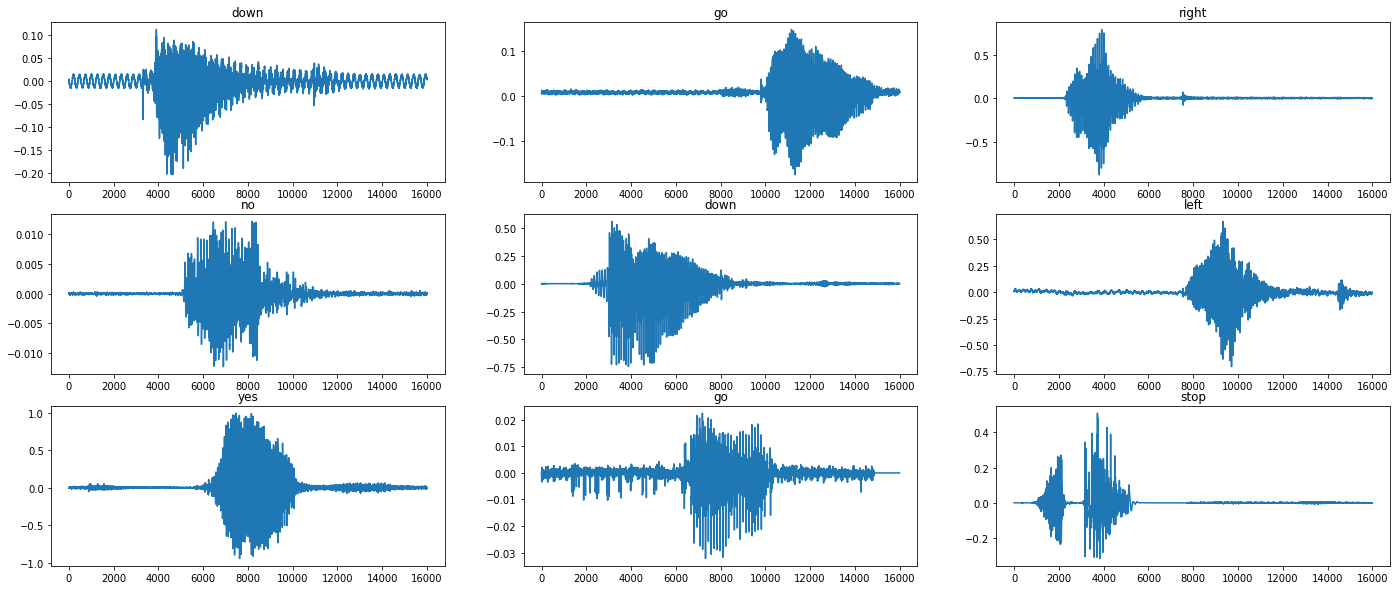

In [9]:
#seeing the data in one of our batches
for x, y in X_train.take(1):
    print(x)
    print(label_names[y])

#plotting the data
plt.figure(figsize=(24, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.plot(x[i].numpy())
    plt.title(label_names[y[i]])
plt.show()

In [10]:
#shape od the data
for x, y in X_train.take(1):
    print("Shape of x: ", x.shape)
    print("Shape of y: ", y.shape)

Shape of x:  (64, 16000)
Shape of y:  (64,)


In [11]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram
    spectrogram = tf.signal.stft(
        signals=waveform, # shape of the waveform
        frame_length=255, # length of the window
        frame_step=128, # step size
    )
    # Convert the complex spectrogram to a magnitude spectrogram
    spectrogram = tf.abs(spectrogram) 
    return spectrogram

In [12]:
for i in range(3):
    labels = label_names[y[i]]
    waveform = x[i]
    spectrogram = get_spectrogram(waveform)

    print("label:", labels)
    print("waveform shape:", waveform.shape)
    print("spectrogram shape:", spectrogram.shape)
    print("Audio playbacl:")
    # Play the audio
    display.display(display.Audio(waveform, rate=16000))


label: right
waveform shape: (16000,)
spectrogram shape: (124, 129)
Audio playbacl:


label: up
waveform shape: (16000,)
spectrogram shape: (124, 129)
Audio playbacl:


label: no
waveform shape: (16000,)
spectrogram shape: (124, 129)
Audio playbacl:


In [13]:
#a fumction to plot the spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3, "Spectrogram must be 2D or 3D"
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spectrogram = np.log(spectrogram.T + np.finfo(float).eps)   
    height = log_spectrogram.shape[0]
    width = log_spectrogram.shape[1]
    x = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    y = range(height)
    ax.pcolormesh(x, y, log_spectrogram, shading='gouraud')

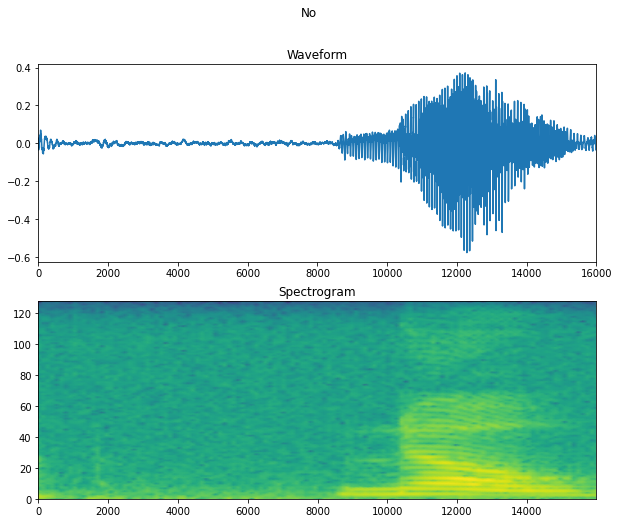

In [14]:
fig, ax = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0]) 
ax[0].plot(timescale, waveform.numpy())
ax[0].set_title("Waveform")
ax[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), ax[1])
ax[1].set_title("Spectrogram")
plt.suptitle(labels.title())
plt.show()

# Play the audio
display.display(display.Audio(waveform, rate=16000))

In [15]:
def make_spec_ds(ds): 
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [94]:
train_spectogram_ds = make_spec_ds(X_train)
test_spectogram_ds = make_spec_ds(X_test)

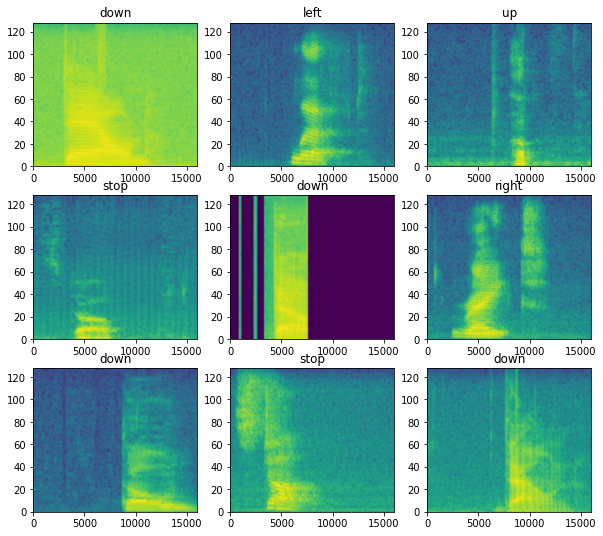

In [31]:
for example_spec, example_labels in train_spectogram_ds.take(1): #taking one batch of training data to show
    break

rows = 3
cols = 3
n = rows *cols
fig, axes = plt.subplots(rows, cols, figsize=(10,9))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spec[i].numpy(),ax)
    ax.set_title(label_names[example_labels[i].numpy()])

plt.show()


In [95]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [96]:
example_spec.shape

TensorShape([64, 124, 129])

In [97]:
for spec, label in train_spectogram_ds.take(1):
    print("Sample shape:", spec.shape)


Sample shape: (64, 124, 129)


In [98]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks

# 1. Data Preparation (with your channel dimension addition)
def add_channel_dimension(ds):
    return ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))

train_spectogram_ds = train_spectogram_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
test_spectogram_ds = test_spectogram_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

# Verify dataset shapes
print("Train dataset element spec:", train_spectogram_ds.element_spec)
print("Test dataset element spec:", test_spectogram_ds.element_spec)

# 2. Get input shape from dataset
sample_input, _ = next(iter(train_spectogram_ds.take(1)))
input_shape = sample_input.shape[1:]  # Exclude batch dimension
print("Model input shape:", input_shape)

# 3. Build Model with Proper Normalization
# First create normalization layer separately
norm_layer = layers.Normalization()

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),  # Standardize size
    norm_layer,  # Reference to our pre-created layer
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_names))  # Use your label_names count
])

# 4. Adapt Normalization
print("Adapting normalization layer...")
norm_layer.adapt(train_spectogram_ds.map(lambda x, y: x))

# 5. Compile (using your exact parameters)
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# 6. Train with Early Stopping (your parameters)
EPOCHS = 15
history = model.fit(
    train_spectogram_ds,
    validation_data=test_spectogram_ds,
    epochs=EPOCHS,
    callbacks=[callbacks.EarlyStopping(verbose=1, patience=2)],
)

# 7. Verification
print("Training completed successfully!")
print("Final validation accuracy:", history.history['val_accuracy'][-1])

Train dataset element spec: (TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Test dataset element spec: (TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Model input shape: (124, 129, 1)
Adapting normalization layer...
Epoch 1/15
100/100 [==============================] - 10s 89ms/step - loss: 1.7335 - accuracy: 0.3678 - val_loss: 1.2286 - val_accuracy: 0.6519
Epoch 2/15
100/100 [==============================] - 9s 91ms/step - loss: 1.1224 - accuracy: 0.6205 - val_loss: 0.8041 - val_accuracy: 0.7756
Epoch 3/15
100/100 [==============================] - 21s 207ms/step - loss: 0.8203 - accuracy: 0.7264 - val_loss: 0.6710 - val_accuracy: 0.8213
Epoch 4/15
100/100 [==============================] - 14s 134ms/step - loss: 0.6777 - accuracy: 0.7700 - val_loss: 0.5483 - val_accuracy: 0.8344
Epoch 5/15
100/100 [==============================] - 8s 